In [395]:
from src.process import *
from src.models import *
from src.utils import *
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import os 
import sys
from datasets import load_dataset, Dataset, load_from_disk
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
df = get_encoders()
print(df)

                encoder  size         desc
0      all-MiniLM-L6-v2   384  TO COMPLETE
1     all-mpnet-base-v2   768  TO COMPLETE
2  all-distilroberta-v1   768  TO COMPLETE
3          gtr-t5-large   768  TO COMPLETE
4  all-roberta-large-v1  1024  TO COMPLETE


In [321]:
idx_encoder = 3
encoder = df.iloc[idx_encoder]['encoder']
size_embedding = df.iloc[idx_encoder]['size']

In [322]:
_, _, test = load_data_embedded(encoder, test_only=True)

In [204]:
model = torch.load('models/' + 'biLSTM_200_3_' + encoder,  map_location=torch.device(device))
model = model.to(device)

In [206]:
## A toi de jouer

In [364]:
def get_model_stats(model, test, nb_cat=4):
    predictions = []
    for i in range(len(test)):
        emb = np.array(test[i]['embeddings'])
        emb = torch.from_numpy(emb).to(torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(emb)
        predictions.append(torch.argmax(pred, axis=1).cpu().numpy())
        
    max_len = max(map(len, test['act']))
    res = np.nan * np.ones(shape=(len(test), max_len))
    true_mat = np.nan * np.ones(shape=(len(test), max_len))
    pred_mat = np.nan * np.ones(shape=(len(test), max_len))
    res_len = np.zeros((max_len-1, 2), dtype=int)
    res_cat = np.zeros((nb_cat, 2), dtype=int)
    cat_pos = np.zeros((max_len, 4), dtype=int)
    res_last = 0

    for i in range(len(test)):
        true = np.array(test[i]['act']) - 1
        res[i, 0:len(true)] = true == predictions[i]
        true_mat[i, 0:len(true)] = true 
        pred_mat[i, 0:len(true)] = predictions[i] 
        res_len[len(true)-2, 0] += (true == predictions[i]).sum()
        res_len[len(true)-2, 1] += len(true)
        for j in range(len(true)):
            res_cat[true[j], 0] += predictions[i][j] == true[j]
            res_cat[true[j], 1] += 1
            cat_pos[j, true[j]] += 1
        res_last += predictions[i][-1] == true[-1]
        

    accuracy = np.nansum(res) / np.sum(~np.isnan(res))
    acc_per_position = np.nansum(res, axis=0) / np.sum(~np.isnan(res), axis=0)
    acc_per_len = res_len[:, 0] / res_len[:, 1]
    acc_first = acc_per_position[0]
    acc_last = res_last / len(test)
    return accuracy, acc_per_position, acc_per_len, acc_first, acc_last

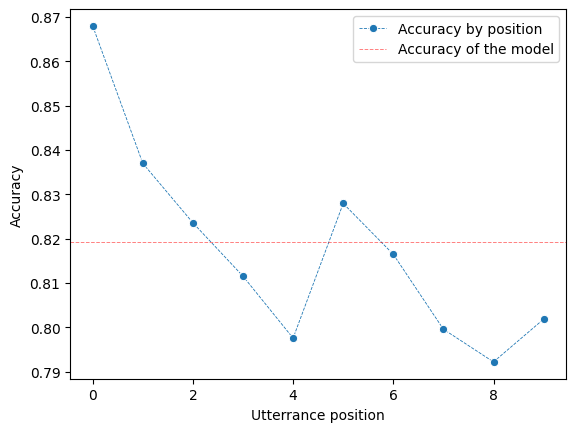

In [244]:
plot = sns.lineplot(data= acc_per_position[:10], marker='o', linestyle='dashed', linewidth=0.6, markevery = [i for i in range(0, 10, 1)],label="Accuracy by position")
plot.set(xlabel = "Utterrance position", ylabel = "Accuracy")
plot.axhline(accuracy, color='r', linestyle='dashed', alpha=0.5, linewidth=0.7,label="Accuracy of the model")
plot.legend()
plt.show()

/tmp/ipykernel_14463/1701191517.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(range(0,11,2))


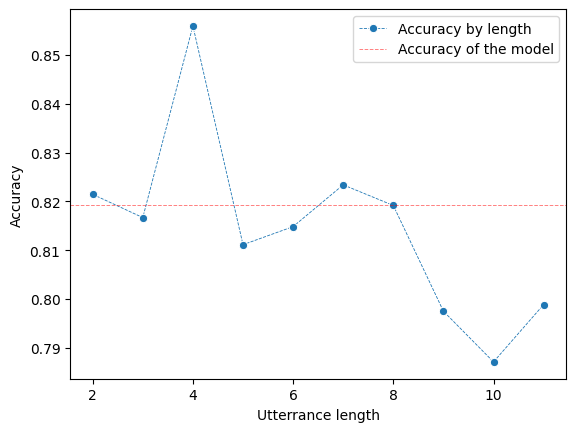

In [237]:
plot = sns.lineplot(data= acc_per_len[:10], marker='o', linestyle='dashed', linewidth=0.6, markevery = range(0, 10, 1),label="Accuracy by length")
plot.set(xlabel = "Utterrance length", ylabel = "Accuracy")
plot.axhline(accuracy, color='r', linestyle='dashed', alpha=0.5, linewidth=0.7,label="Accuracy of the model")
plot.set_xticklabels(range(0,11,2))
plot.legend()
plt.show()

In [243]:
# Proportion categories per position
cat_pos / cat_pos.sum(axis=1)[:,None]

array([[0.277     , 0.497     , 0.226     , 0.        ],
       [0.492     , 0.263     , 0.143     , 0.102     ],
       [0.41753653, 0.35803758, 0.16597077, 0.05845511],
       [0.53050109, 0.208061  , 0.1459695 , 0.11546841],
       [0.43184885, 0.29554656, 0.17139001, 0.10121457],
       [0.50844854, 0.21812596, 0.15975422, 0.11367127],
       [0.42696629, 0.30337079, 0.17228464, 0.09737828],
       [0.53862213, 0.19415449, 0.14822547, 0.11899791],
       [0.45974026, 0.25714286, 0.16623377, 0.11688312],
       [0.55108359, 0.16718266, 0.14551084, 0.13622291],
       [0.49565217, 0.21304348, 0.16521739, 0.12608696],
       [0.55737705, 0.1420765 , 0.1420765 , 0.15846995],
       [0.47058824, 0.28431373, 0.09803922, 0.14705882],
       [0.625     , 0.1625    , 0.125     , 0.0875    ],
       [0.39215686, 0.17647059, 0.23529412, 0.19607843],
       [0.51219512, 0.2195122 , 0.07317073, 0.19512195],
       [0.60869565, 0.13043478, 0.2173913 , 0.04347826],
       [0.3125    , 0.4375    ,

In [409]:
list_models = os.listdir('models/')
list_models = sorted(list_models, key = lambda x:x.split('_')[-1] + x.split('_')[0][1::])

res = []
for i, name in enumerate(tqdm(list_models)):
    model = torch.load('models/' + name,  map_location=torch.device(device))
    model = model.to(device)
    encoder = name.split('_')[-1]
    _, _, test = load_data_embedded(encoder, test_only=True)
    accuracy, acc_per_position, acc_per_len, acc_first, acc_last = get_model_stats(model, test)
    nb_parameters = get_nb_parameters(model)
    res.append([encoder ,'_'.join(name.split('_')[:-1]), nb_parameters, accuracy, acc_per_position, acc_per_len, acc_first, acc_last])
    
df_res = pd.DataFrame(res, columns=['encoder', 'model', 'nb_parameters', 'accuracy', 'acc_per_position', 'acc_per_len', 'acc_first', 'acc_last'])

100%|██████████| 32/32 [02:22<00:00,  4.45s/it]


In [416]:
df_res

,encoder,model,nb_parameters,accuracy,acc_per_position,acc_per_len,acc_first,acc_last
0,all-MiniLM-L6-v2,MLP_,25748,0.769767,"[0.855, 0.768, 0.7933194154488518, 0.751633986...","[0.75, 0.75, 0.7951977401129944, 0.72222222222...",0.768,0.693
1,all-MiniLM-L6-v2,RNN_100_2,69204,0.754780,"[0.822, 0.757, 0.7630480167014614, 0.748366013...","[0.75, 0.725, 0.786723163841808, 0.71555555555...",0.757,0.709
2,all-MiniLM-L6-v2,GRU_100_2,206804,0.767442,"[0.835, 0.775, 0.778705636743215, 0.7614379084...","[0.7619047619047619, 0.7583333333333333, 0.799...",0.775,0.728
3,all-MiniLM-L6-v2,LSTM_100_2,275604,0.777649,"[0.849, 0.781, 0.7766179540709812, 0.766884531...","[0.7738095238095238, 0.7666666666666667, 0.810...",0.781,0.748
4,all-MiniLM-L6-v2,biGRU_100_2,473604,0.784367,"[0.84, 0.796, 0.7985386221294363, 0.7690631808...","[0.7976190476190477, 0.8, 0.8305084745762712, ...",0.796,0.748
5,all-MiniLM-L6-v2,biLSTM_50_4,357204,0.792119,"[0.84, 0.798, 0.8100208768267223, 0.7777777777...","[0.8809523809523809, 0.8, 0.8347457627118644, ...",0.798,0.754
6,all-MiniLM-L6-v2,biRNN_100_3,218804,0.780362,"[0.837, 0.778, 0.7922755741127349, 0.760348583...","[0.8333333333333334, 0.7833333333333333, 0.822...",0.778,0.763
7,all-MiniLM-L6-v2,biRNN_200_3,717604,0.781912,"[0.824, 0.786, 0.7922755741127349, 0.760348583...","[0.8095238095238095, 0.775, 0.8248587570621468...",0.786,0.756
8,all-mpnet-base-v2,MLP_,50324,0.785788,"[0.859, 0.786, 0.8121085594989561, 0.760348583...","[0.8214285714285714, 0.7666666666666667, 0.819...",0.786,0.716
9,all-mpnet-base-v2,RNN_100_2,107604,0.770413,"[0.844, 0.783, 0.7776617954070981, 0.742919389...","[0.8690476190476191, 0.725, 0.8008474576271186...",0.783,0.724


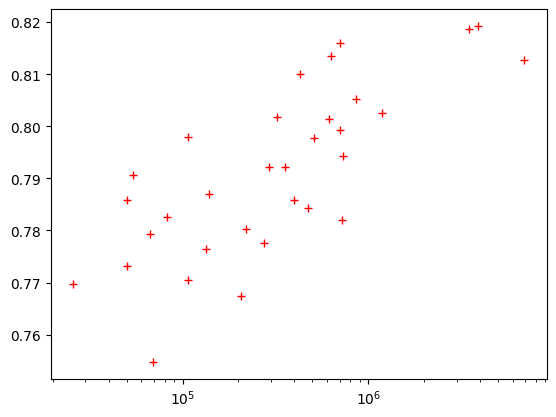

In [422]:
plt.plot(df_res['nb_parameters'], df_res['accuracy'], 'r+')
plt.xscale('log')